In [2]:
import numpy as np
from eden import graph
from sklearn.decomposition import TruncatedSVD

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import matplotlib
import umap
import utilities

from evaluator import Evaluator
from sklearn.neighbors import KNeighborsClassifier
import sklearn as sk
from sklearn.model_selection import train_test_split


# Load dataset 624249 

In [3]:
import networkx as nx
def load_generated_data_classification(path):
    
    graphs = nx.read_gpickle(path+'/'+'graphs.gpickle')
    labels = list(np.load(path+'/'+'labels.npy'))
    
    return (graphs,labels)

def sub_sample_classification(graphs,labels, n_graphs):
    
    graphs, labels = sk.utils.shuffle(graphs, labels)
        
    return (graphs[0:n_graphs],labels[0:n_graphs])

In [4]:
graphs, labels = load_generated_data_classification("generate_graphs/651741_pos_neg")

In [5]:
#graphs, labels = sub_sample_classification(graphs,labels,1000)

In [6]:
# prepross 
for g in graphs:
    for node in g.nodes():
        g.nodes[node]['vec'] = []
for g in graphs:
    for edge in g.edges():
        g.edges[edge]['vec'] = []

In [7]:
graphs_train,graphs_test,labels_train,labels_test = train_test_split(graphs,labels,test_size=0.3)

In [8]:
print(len(graphs_train))

565


In [9]:
vectoriz = graph.Vectorizer(complexity = 5)
data_train = vectoriz.transform(graphs_train)
data_test = vectoriz.transform(graphs_test)

# MODEL1: Vect PCA_500 UMAP_2

In [10]:
pca_1 = TruncatedSVD(n_components=500)
m1_200_data_train = pca_1.fit(data_train).transform(data_train)
m1_200_data_test = pca_1.transform(data_test)

In [11]:
uma = umap.UMAP(n_components=2)
res_m1_train = uma.fit(m1_200_data_train,labels_train).transform(m1_200_data_train)
res_m1_test = uma.transform(m1_200_data_test)

		 +++++ ORIGINAL SPACE +++++
K.N.N.  acc:  0.7727318840579709

		 +++++ TEST +++++
K.N.N.  acc:  0.7123985507246375

		 +++++ TRAIN +++++
K.N.N.  acc:  1.0


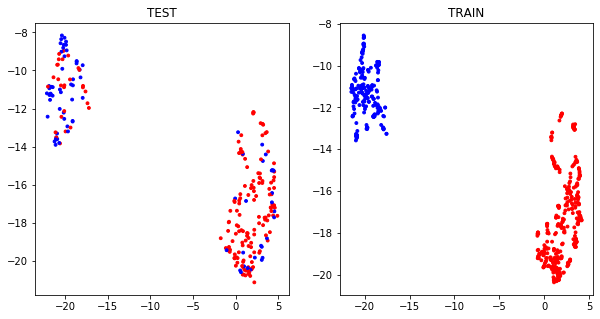

In [18]:
print("\t\t +++++ ORIGINAL SPACE +++++")
eva = Evaluator(KNeighborsClassifier(n_neighbors = 1))
acc,_,_,_ = eva.performance_with_kfold(data_test,labels_test)
print("K.N.N.  acc: ",np.mean(acc))


plot_embedding(res_m1_test,labels_test,res_m1_train,labels_train)

# MODEL5: Vect -- PCA_500 -- SUPERVISED_AUTOENCODER_60 -- UMAP 2
### with my_callback sinusoidal

In [23]:
from keras import Input
from keras.layers import Dense, Dropout
from keras import Model
from keras.initializers import RandomNormal
from keras.losses import mean_squared_error

from keras.callbacks import EarlyStopping, TensorBoard

In [21]:
from embedder import Preprocessing_scaler
from sklearn.preprocessing import Normalizer

pca_4 = TruncatedSVD(n_components=500)
m4_200_data_train = pca_4.fit(data_train).transform(data_train)
m4_200_data_test = pca_4.transform(data_test)

# SCALER
scaler_4 = Preprocessing_scaler([0, 1])
m4_200_scal_data_train = scaler_4.fit(m4_200_data_train).transform(m4_200_data_train)
m4_200_scal_data_test = scaler_4.transform(m4_200_data_test)

# NORMALIZER
normalizer_4 = Normalizer(copy=True, norm='l2')  
m4_200_norm_data_train = normalizer_4.fit(m4_200_scal_data_train).transform(m4_200_scal_data_train)
m4_200_norm_data_test = normalizer_4.transform(m4_200_scal_data_test)

input_auto = len(m4_200_scal_data_train[0])

In [53]:
iniz = RandomNormal(mean=0, stddev=0.05)
w_dec = K.variable(1)
w_cla = K.variable(0.1)


prob_drop = 0.5
x_in = Input(shape=(input_auto,))
enc = Dense(input_auto*2, activation="relu",kernel_initializer=iniz)(x_in)
enc = Dropout(prob_drop)(enc)
enc = Dense(input_auto, activation="relu",kernel_initializer=iniz)(enc)
enc = Dense(60, activation="sigmoid",kernel_initializer=iniz)(enc)

decode = Dense(input_auto, activation="relu",name='decoder',kernel_initializer=iniz)(enc)

cla = Dense(10, activation='relu', name='cla_10')(enc)
cla = Dense(2, activation='softmax',name='classifier')(cla)


sup_autoencoder = Model(inputs = x_in, outputs = [decode,cla])
sup_autoencoder.compile(optimizer='adam',
                            metrics={'decoder': 'mse', 'classifier': ['acc']},
                            loss = {'decoder': 'mean_squared_error', 'classifier': 'categorical_crossentropy'},
                            loss_weights = {'decoder': w_dec, 'classifier': w_cla})

In [54]:
path = "logs_sintetici/test_PROVA_700nk"
tb = TensorBoard(log_dir=path)

epochs = 500
my = MyCallback_sinusoidal(w_dec = w_dec,
                           w_cla = w_cla,
                           n_epoch = epochs,
                           n_period = 4,
                           scal_c = 3000,
                           scal_d = 5)

# 4 - 50 - 5
h = sup_autoencoder.fit(m4_200_norm_data_train,
                    {'decoder': m4_200_norm_data_train, 'classifier': utilities.from_np_to_one_hot(labels_train)},
                    epochs=epochs,    
                    verbose=0,
                    validation_split=0.2,
                    callbacks=[tb,my])

a = sup_autoencoder.evaluate(m4_200_norm_data_test,[m4_200_norm_data_test,utilities.from_np_to_one_hot(labels_test)])
n = sup_autoencoder.metrics_names
for i in range(0,len(a)):
    print(str(n[i])+" "+str(a[i]))

243/243 [==============================] - 0s 82us/step
loss 0.000325058825714552
decoder_loss 0.0008280057174540719
classifier_loss 0.47893432653489915
decoder_mean_squared_error 0.0008280057174540719
classifier_acc 0.8106995889679395


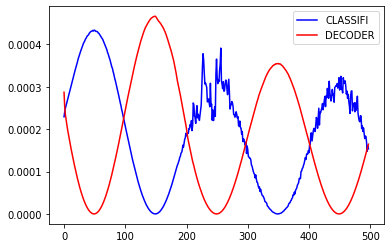

In [55]:
plot_loss(my,h)

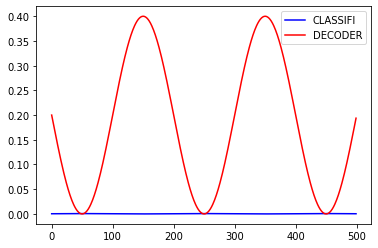

In [56]:
plt.plot(my.w_cals,label="CLASSIFI",c = 'b')
plt.plot(my.w_decs,label="DECODER", c="r")
plt.legend()

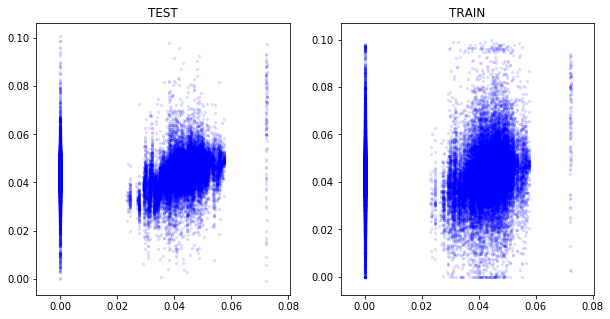

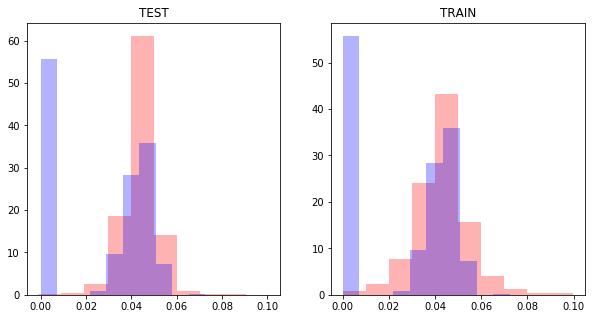

In [57]:
pred_test = sup_autoencoder.predict(m4_200_norm_data_test)[0]
pred_train = sup_autoencoder.predict(m4_200_norm_data_train)[0]

plot_auto(pred_test,pred_train,m4_200_norm_data_test,m4_200_norm_data_train)

# UMAP from 60 to 2

In [58]:
encoder_3 = Model(x_in, enc)
res_sup_auto_train = encoder_3.predict(m4_200_norm_data_train)

uma_4 = umap.UMAP(n_components=2)
res_m4_train = uma_4.fit(res_sup_auto_train,labels_train).transform(res_sup_auto_train)

res_sup_auto_test = encoder_3.predict(m4_200_norm_data_test)
res_m4_test = uma_4.transform(res_sup_auto_test)


		 +++++ TEST +++++
K.N.N.  acc:  0.6505652173913044

		 +++++ TRAIN +++++
K.N.N.  acc:  0.9679129642287536


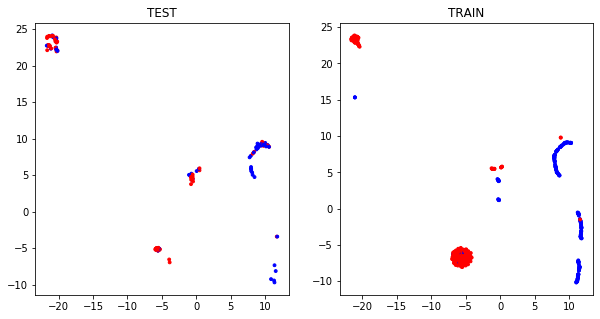

In [59]:
plot_embedding(res_m4_test,labels_test,res_m4_train,labels_train)

In [13]:
import keras.backend.tensorflow_backend as K
from keras import callbacks
import math

class MyCallback_sinusoidal(callbacks.Callback):
    def __init__(self, w_dec, w_cla, n_epoch,n_period,scal_c,scal_d):
        
        self.n_epoch = n_epoch
        self.w_dec = w_dec
        self.w_cla = w_cla
        
        self.w_cals = []
        self.w_decs = []
        
        
        
        samples_s = np.linspace(-(math.pi), n_period*(math.pi),n_epoch+1)
        

        s = np.sin(samples_s)
        c = -s
        s = s + 1
        c = c + 1

        s = s/scal_d
        c = c/scal_c        
        
        self.sin = s
        self.cos = c

        
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.w_cla, self.cos[epoch])
        K.set_value(self.w_dec, self.sin[epoch])

            
        self.w_decs.append(K.get_value(self.w_dec))
        self.w_cals.append(K.get_value(self.w_cla))

In [14]:
def plot_loss(my,h):
    clas = my.w_cals
    clal = h.history['classifier_loss']

    dec = my.w_decs
    decl = h.history['decoder_loss']

    c = []
    d = []

    for i in range(len(dec)):
        c.append(clas[i]*clal[i])
        d.append(dec[i]*decl[i])

    plt.plot(c[1:-1],label="CLASSIFI",c = 'b')
    plt.plot(d[1:-1],label="DECODER", c="r")
    plt.legend()
    plt.show()

In [15]:
from keras import callbacks

class MyCallback(callbacks.Callback):
    def __init__(self, w_dec, w_cla, n_epoch):
        
        self.n_epoch = n_epoch
        self.w_dec = w_dec
        self.w_cla = w_cla
        self.w_cals = []
        self.w_decs = []
    # customize your behavior
        
    def on_epoch_end(self, epoch, logs={}):
        
        
        cla = logs['classifier_loss']
        dec = logs['decoder_loss']
        # redi uguale il peso delle 2 loss
        tmp = dec/cla
        
        # dai piu peso al decoder al crescere delle epoche
        new_dec = 5*epoch / (self.n_epoch) 
        
        self.w_decs.append(K.get_value(self.w_dec))
        self.w_cals.append(K.get_value(self.w_cla))
        
        K.set_value(self.w_cla, tmp)
        K.set_value(self.w_dec, new_dec)

In [16]:
def plot_embedding(res_test,labels_test,res_train,labels_train):

    colors = ['red','blue']
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    x = res_test[:,0]
    y = res_test[:,1]
    plt.title("TEST")
    plt.scatter(x,y,s=8,c=labels_test,cmap=matplotlib.colors.ListedColormap(colors))


    plt.subplot(122)
    x = res_train[:,0]
    y = res_train[:,1]
    plt.title("TRAIN")
    plt.scatter(x,y,s=8,c=labels_train,cmap=matplotlib.colors.ListedColormap(colors))


    print("\n\t\t +++++ TEST +++++")
    eva = Evaluator(KNeighborsClassifier(n_neighbors = 1))
    acc, pre, rec, f = eva.performance_with_kfold(res_test,labels_test)
    print("K.N.N.  acc: ",np.mean(acc))
    
    print("\n\t\t +++++ TRAIN +++++")
    eva = Evaluator(KNeighborsClassifier(n_neighbors = 1))
    acc, pre, rec, f = eva.performance_with_kfold(res_train,labels_train)
    print("K.N.N.  acc: ",np.mean(acc))

In [17]:


def plot_auto(pred_test,pred_train,data_test,data_train):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title("TEST")
    for i in range(0,100):
        a = pred_test[i]
        b = data_test[i]
        plt.scatter(a,b,s=5,c='b',alpha=0.1)

    plt.subplot(122)
    plt.title("TRAIN")
    for i in range(0,100):
        a = pred_train[i]
        b = data_train[i]
        plt.scatter(a,b,s=5,c='b',alpha=0.1)
        

    tmp = []

    for a in data_test:
        for b in a:
            tmp.append(b)

    tmp_2 = []
    for a in pred_test:
        for b in a:
            tmp_2.append(b)

    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title("TEST")
    plt.hist(tmp,alpha=0.3,color='red',bins=10,density=True)
    plt.hist(tmp_2,alpha=0.3,color='blue', bins=10,density=True)
    tmp = []

    for a in data_train:
        for b in a:
            tmp.append(b)

    tmp_2 = []
    for a in pred_train:
        for b in a:
            tmp_2.append(b)

    plt.subplot(122)
    plt.title("TRAIN")
    plt.hist(tmp,alpha=0.3,color='red',bins=10,density=True)
    plt.hist(tmp_2,alpha=0.3,color='blue', bins=10,density=True)

    plt.show()


